# **Apple Identification Model** 

See the [README.md](README.md) for a full project overview, setup instructions, and additional context.

## **Imports**

In [6]:
# Database API
from kaggle.api.kaggle_api_extended import KaggleApi

# File and directory management
import os
import shutil
from pathlib import Path

# Data manipulation
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Computer vision
import cv2

# Machine learning
import tensorflow as tf

# Keras for deep learning
from keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: []


## **Table of Contents**

[**Dataset**](#dataset) — Overview of the dataset and filtering process

- [**Filtering Data**](#filtering-data) — Selecting only apple images from the full dataset  
- [**Data Preprocessing**](#data-preprocessing) — Cleaning and organizing the apple dataset for training  
- [**Dataset Structure**](#dataset-structure) — Explaining the layout of the training, test, and validation sets  
- [**Examples of Each Species**](#examples-of-each-species) — Visualizing the apple species in the dataset  
  
[**Model**](#model) — CNN architecture for apple species classification

- [**Model Architecture**](#model-architecture) — Structure and layers of the neural network  
- [**Training**](#training) — Optimizer, loss function, and training parameters  
- [**Evaluation**](#evaluation) — Accuracy, loss, and model performance analysis  

[**Results**](#results) — Final performance metrics and visualizations

[**Conclusion**](#conclusion) — Summary of results and future work

## **Dataset**

The dataset used in this project is the **Fruits360** dataset from Kaggle, which contains images of a wide variety of fruits. For the purposes of this project, the dataset will be filtered to include only apples and their different varieties.

### **Filtering Data**

The original dataset contains a wide variety of fruit images, but for this project, we are only interested in apple images.

In this step, we will:
- Download the full fruit dataset using the Kaggle API
- Filter out only the apple-related data
- Create a clean, organized apple-only dataset to use for training and evaluation

In [8]:
kaggle_api = KaggleApi()
kaggle_api.authenticate()

dataset = Path('fruits_dataset')

if dataset.is_dir():
    print('Fruits dataset already downloaded')
else:
    print('Downloading fruits dataset')
    kaggle_api.dataset_download_files('moltean/fruits', path=dataset, unzip=True)

Fruits dataset already downloaded


In [9]:
dataset = dataset / 'fruits-360_original-size/fruits-360-original-size'

apple_dataset = Path('apple_dataset')

apple_species = [
    'apple_breaburn', 
    'apple_crimson_snow',
    'apple_golden', 
    'apple_granny_smith', 
    'apple_hit',
    'apple_pink_lady',
    'apple_red', 
    'apple_red_delicious',
    'apple_red_yellow'
]

print(f'{len(apple_species)} species of apples:')
for species in apple_species:
    print(f'  - {species.replace("apple_", "").replace("_", " ").title()}')

9 species of apples:
  - Breaburn
  - Crimson Snow
  - Golden
  - Granny Smith
  - Hit
  - Pink Lady
  - Red
  - Red Delicious
  - Red Yellow


### **Data Preprocessing**

Fortunately, the dataset was already split into training, validation, and test sets, which simplifies the initial setup.

**TODO:**
- Create a filtered dataset containing only apple species
- Relabel folders as needed and remove any irrelevant or unwanted data

In [10]:
def is_apple_species(name: str, species: list[str]) -> bool:
    return any(specie in name.lower() for specie in species)

def copy_apple_dirs(source_dir: Path, dest_dir: Path, species_list=apple_species):
    for dir in source_dir.iterdir():
        if (dir.is_dir() 
            and is_apple_species(dir.name, species_list) 
            and not (dest_dir / dir.name).exists()
        ):
            shutil.copytree(dir, dest_dir / dir.name)

In [11]:
# Create apple dataset
apple_trainning = Path(apple_dataset / 'train')
copy_apple_dirs(dataset / 'Training', apple_trainning)

apple_testing = Path(apple_dataset / 'test')
copy_apple_dirs(dataset / 'Test', apple_testing)

apple_validation = Path(apple_dataset / 'validation')
copy_apple_dirs(dataset / 'Validation', apple_validation)

In [12]:
# Clean up names and labels
for dir in apple_dataset.iterdir():
    for dir in dir.iterdir():
        new_name = dir.name.replace('apple_', '')
        updated_path = dir.parent / new_name
        if not updated_path.exists():
            dir.rename(dir.parent / new_name)

**Possible Future work:**
- Combine duplicate species, for example: `golden_1`, `golden_2`, `golden_3` $\longrightarrow$ `golden`
- Relabel imgs to more explicit labels, for example: `r0_1.jpg` $\longrightarrow$ `roation_0_golden_1.jpg`
- Add more apples from other datasets

### **Dataset Structure**

**[2025-03-23]** — The dataset currently mirrors the structure of the original source in order to maintain clarity and consistency during this initial phase of model development. Future changes to the structure may be implemented as needed and will be documented here.

Each folder represents a distinct apple species class. In some cases, duplicate species are split into separate folders (e.g., `golden_1` and `golden_2`). Image filenames include rotation labels along the third axis, noted as `r0` or `r1`.

The dataset is divided into three subsets:
- **Training** contains `k + 2` images per apple
- **Validation** contains `k + 1` images
- **Test** contains `k + 3` images

This results in the training set comprising approximately 50% of the total images, while the validation and test sets each contain around 25%.

### **Examples of Each Species**

The following images are examples of the apple species included in the dataset. Each image is labeled with its corresponding species name.

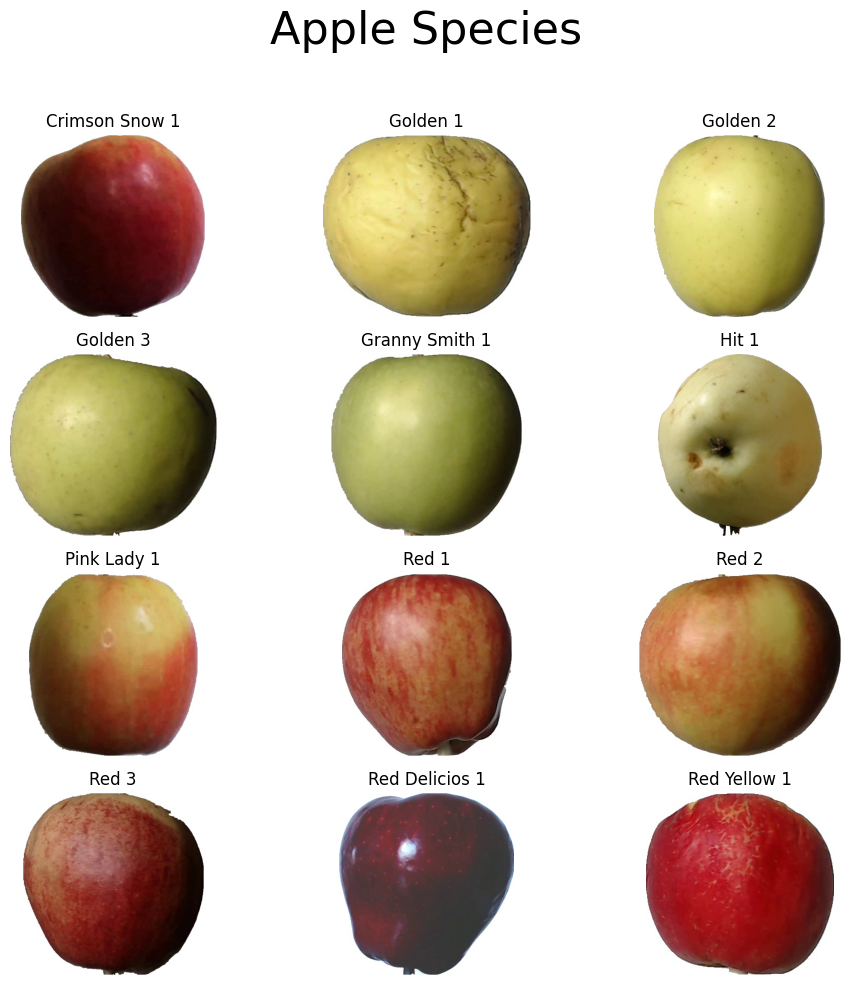

In [13]:
# Display one image from each apple species in a 3x3 grid

def get_imgs(apple_dataset: Path):
    info = []
    for dir in apple_dataset.iterdir():
        if dir.is_dir():
            for img in dir.iterdir():
                if img.suffix in ['.jpg', '.jpeg', '.png']:
                    info.append((dir.name, img))
                    break
    return sorted(info, key=lambda x: x[0])


def display_apple_species(apple_dataset: Path):
    fig, axes = plt.subplots(4, 3, figsize=(10, 10))
    fig.suptitle('Apple Species\n', fontsize=32)
    axes = axes.flatten()
    img_paths = get_imgs(apple_dataset)

    for ax,(name, img_path) in zip(axes, img_paths):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(name.replace('apple_', '').replace('_', ' ').title())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display the apple species
display_apple_species(apple_trainning)


## **Model** 

For this project I will be using a CNN (Convolutional Neural Network) architecture to classify the apple species. 

### **Model Architecture**

In [ ]:
# ----------------------------- TRAINING CONFIG ----------------------------- #

BATCH_SIZE = 64
EPOCHS = 50
TARGET_SIZE = (320, 320)  # Fixed size for consistency

# ----------------------------- DATA GENERATORS ----------------------------- #

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    apple_trainning,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    apple_testing,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical'
)

steps_per_epoch = int(np.ceil(train_generator.samples / BATCH_SIZE))
validation_steps = int(np.ceil(test_generator.samples / BATCH_SIZE))

# --------------------------------- MODEL ---------------------------------- #

class AppleClassifier:
    def __init__(self, input_shape: tuple[int, int, int], num_classes: int):
        self.model = Sequential([
            Input(shape=input_shape),
            Conv2D(64, kernel_size=3, activation='relu'),
            MaxPool2D(),
            Conv2D(32, kernel_size=3, activation='relu'),
            MaxPool2D(),
            Conv2D(32, kernel_size=3, activation='relu'),
            MaxPool2D(),
            Dropout(0.5),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(128, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit_data(self, train_generator, steps_per_epoch, validation_data, validation_steps, epochs=EPOCHS, callbacks=None, verbose=1):
        return self.model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_data,
            validation_steps=validation_steps,
            epochs=epochs,
            callbacks=callbacks,
            verbose=verbose
        )

    def save(self, filepath):
        self.model.save(filepath)

    def summary(self):
        return self.model.summary()

# ----------------------------- EARLY STOPPING ----------------------------- #

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# --------------------------- INSTANTIATE & TRAIN --------------------------- #

model = AppleClassifier(
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
    num_classes=train_generator.num_classes
)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit_data(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

# ----------------------------- SAVE THE MODEL ----------------------------- #

model.save("apple_classifier.keras")

Found 7734 images belonging to 24 classes.
Found 3864 images belonging to 24 classes.


c:\Users\robbykap\miniconda3\envs\tf-gpu\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1528 - loss: 2.7663

c:\Users\robbykap\miniconda3\envs\tf-gpu\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


121/121 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.1537 - loss: 2.7607 - val_accuracy: 0.4327 - val_loss: 1.0510
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.4620 - loss: 1.1049 - val_accuracy: 0.4961 - val_loss: 0.8249
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.4958 - loss: 0.8554 - val_accuracy: 0.4930 - val_loss: 0.8142
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.4886 - loss: 0.8310 - val_accuracy: 0.4997 - val_loss: 0.7486
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.4907 - loss: 0.7975 - val_accuracy: 0.4961 - val_loss: 0.7935
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.4876 - loss: 0.8018 - val_accuracy: 0.4886 - val_loss: 0.7927
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.4967 - loss: 0.7791 - val_accuracy: 0.5000 - val_loss: 0.7200
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.4936 - loss: 0.7387 - val_accuracy: 0.500

### **Training**

### **Evaluation**

## **Results**

## **Conclusion**